# Overview
- nb005のcvが良くなかったので、その解析を行なう
- おそらく、foldごとにtargetの分布差が生じているものだと思われる。
- それを一定にするような方法を考える。

# Const

In [36]:
NB = '006'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
PATH_GROUP = '../data_ignore/output_nb/nb004/group.csv'

# Import everything I need :)

In [37]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from sklearn.model_selection import GroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# My function

In [38]:
def get_696_strategy_fold(group, n_splits, seed=0):
    '''nb004'''
    
    # group == 0 (all_target=0)の分解
    mask_0 = group['group'] == 0
    group_0 = group[mask_0]
    splitter = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    df_fold_0 = pd.DataFrame()
    df_fold_0['fold'] = np.zeros(len(group_0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_0)):
        df_fold_0['fold'][idx_val] = int(i_fold + 1)

    # group != 0 の分解
    mask_not0 = group['group'] != 0
    group_not0 = group[mask_not0]
    splitter = GroupKFold(n_splits=n_splits)
    df_fold_not0 = pd.DataFrame()
    df_fold_not0['fold'] = np.zeros(len(group_not0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_not0, groups=group_not0['group'].values)):
        df_fold_not0['fold'][idx_val] = int(i_fold + 1)

    # fold情報の結合
    df_fold = pd.DataFrame()
    df_fold['sig_id'] = group['sig_id'].values
    df_fold['fold'] = np.zeros(len(group)).astype(int)
    df_fold['fold'][mask_0.values] = df_fold_0['fold'].values
    df_fold['fold'][mask_not0.values] = df_fold_not0['fold'].values
    return df_fold

# Preparation

set

In [39]:
sns.set()
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings('ignore')

<br>

load datasets

In [40]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
# train_nonscored = pd.read_csv(PATH_TRAIN_NONSCORED)
# sub = pd.read_csv(PATH_SUB)
# test_features = pd.read_csv(PATH_TEST)
group = pd.read_csv(PATH_GROUP)

<br>

preprocessing

In [41]:
n_splits = 10
df_fold = get_696_strategy_fold(group, n_splits)

# EDA

In [42]:
targets = train_targets.copy()
del targets['sig_id']

<br>

任意のtargetが1になる回数を各fold毎にプロットする

In [43]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = df_fold['fold'] == n
    count = targets[mask_fold].sum(axis=0).values
    df_count = pd.DataFrame([count], columns=targets.columns)
    list_df.append(df_count)
df_count = pd.concat(list_df, axis=0)
df_count.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

<br>

- 色で表現  
- 黒い部分が0になっている  
- 最大値を300に制限

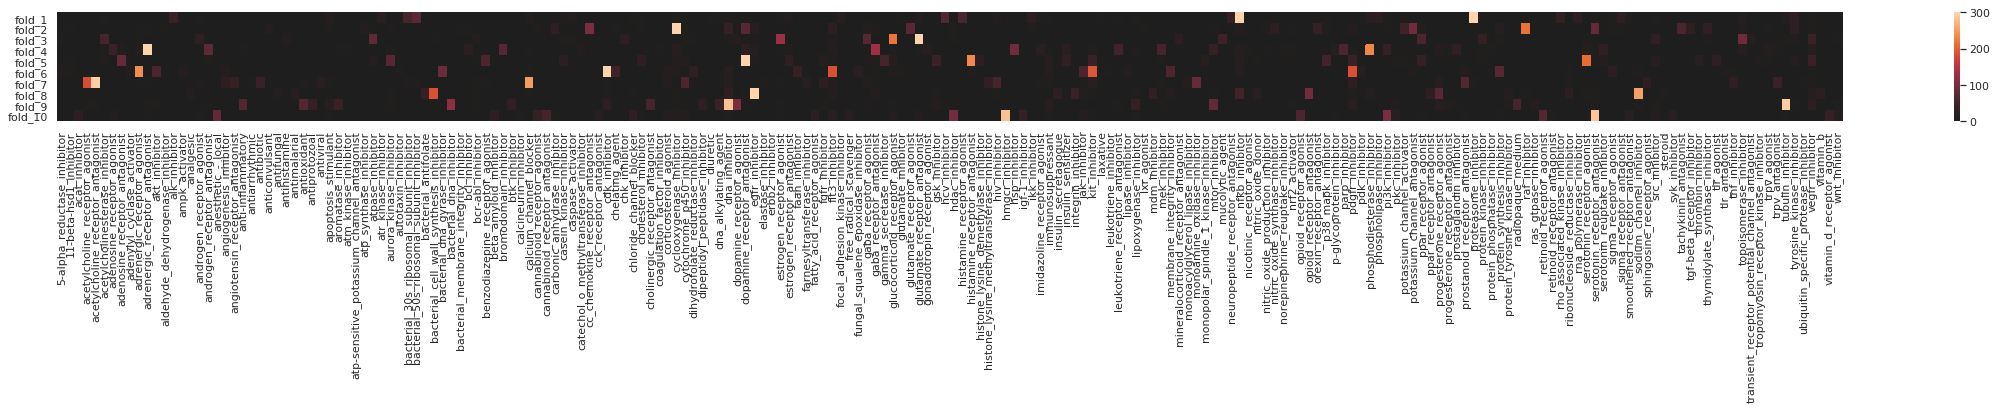

In [44]:
df = df_count
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            vmax=300,
            center=0)

<br>

- binaly表示
- 0の部分を黒、not0の部分を白で表示

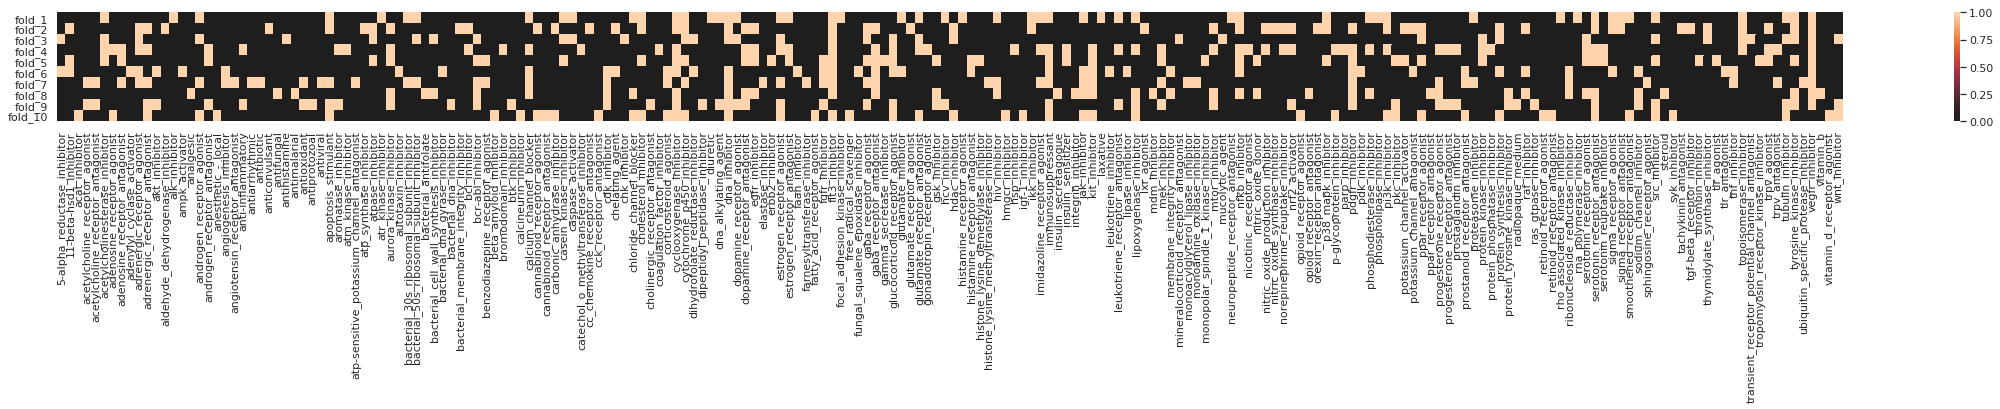

In [45]:
df_bin = df_count.copy()
df_bin[df_count==0] = 0
df_bin[df_count!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)

<br>

各targetが1になるgroup数をカウント

In [46]:
counts = []
for name in targets.columns:
    mask = targets[name] == 1
    count = group[mask]['group'].nunique()
    counts.append(count)

In [47]:
df_group_count_target = pd.DataFrame()
df_group_count_target['target'] = targets.columns
df_group_count_target['n_group'] = counts
df_group_count_target.head()

,target,n_group
0,5-alpha_reductase_inhibitor,2
1,11-beta-hsd1_inhibitor,3
2,acat_inhibitor,1
3,acetylcholine_receptor_agonist,2
4,acetylcholine_receptor_antagonist,2


<br>

上記の内、n_groupが1回のもの

In [48]:
mask_n_group_1 = df_group_count_target['n_group'] == 1
df = df_group_count_target[mask_n_group_1]
print(df_group_count_target[mask_n_group_1].target.values)
df.head()

['acat_inhibitor' 'adenylyl_cyclase_activator'
 'aldehyde_dehydrogenase_inhibitor' 'alk_inhibitor' 'ampk_activator'
 'analgesic' 'anesthetic_-_local' 'angiotensin_receptor_antagonist'
 'antiarrhythmic' 'antibiotic' 'anticonvulsant' 'antifungal'
 'antihistamine' 'antimalarial' 'antiprotozoal' 'antiviral'
 'atm_kinase_inhibitor' 'atp-sensitive_potassium_channel_antagonist'
 'atr_kinase_inhibitor' 'autotaxin_inhibitor' 'bacterial_antifolate'
 'bacterial_dna_gyrase_inhibitor' 'bacterial_dna_inhibitor'
 'bacterial_membrane_integrity_inhibitor' 'bromodomain_inhibitor'
 'btk_inhibitor' 'calcineurin_inhibitor' 'cannabinoid_receptor_antagonist'
 'catechol_o_methyltransferase_inhibitor'
 'cc_chemokine_receptor_antagonist' 'cck_receptor_antagonist'
 'chk_inhibitor' 'coagulation_factor_inhibitor'
 'dipeptidyl_peptidase_inhibitor' 'diuretic' 'elastase_inhibitor'
 'erbb2_inhibitor' 'faah_inhibitor' 'farnesyltransferase_inhibitor'
 'fatty_acid_receptor_agonist' 'focal_adhesion_kinase_inhibitor'
 'fun

,target,n_group
2,acat_inhibitor,1
8,adenylyl_cyclase_activator,1
12,aldehyde_dehydrogenase_inhibitor,1
13,alk_inhibitor,1
14,ampk_activator,1


---> これはやばい。。。  
---> 88のターゲットは、ある一つのグループに属することになる。

# 5-foldした場合の各targetの数を数えてみる

In [49]:
n_splits = 5
splitter = KFold(n_splits=n_splits, shuffle=True, random_state=0)

In [50]:
folds = np.full(len(targets), fill_value=-1)
for i, (idx_trn, idx_val) in enumerate(splitter.split(targets)):
    folds[idx_val] = i + 1
folds = folds.astype(int)

df_kfold = pd.DataFrame()
df_kfold['sig_id'] = df_fold['sig_id'].values
df_kfold['fold'] = folds
df_kfold.head()

,sig_id,fold
0,id_000644bb2,3
1,id_000779bfc,2
2,id_000a6266a,3
3,id_0015fd391,3
4,id_001626bd3,2


<br>

任意のtargetが1になる回数をfold毎に計算

In [51]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = df_kfold['fold'] == n
    count = targets[mask_fold].sum(axis=0).values
    df_count_kfold = pd.DataFrame([count], columns=targets.columns)
    list_df.append(df_count_kfold)
df_count_kfold = pd.concat(list_df, axis=0)
df_count_kfold.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count_kfold

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

<br>

fold毎にtargetの総数が0になっている部分の可視化

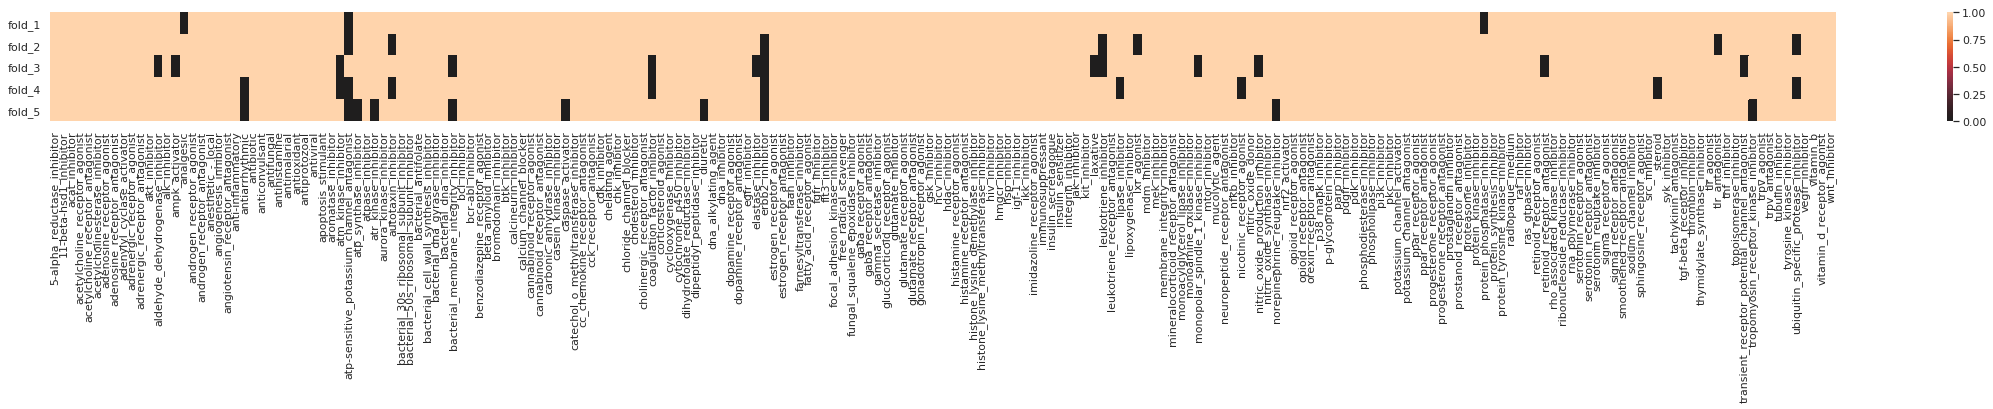

In [52]:
df_bin = df_count_kfold.copy()
df_bin[df_count_kfold==0] = 0
df_bin[df_count_kfold!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)

# multi-stratified-5-foldした場合の各targetの数を数えてみる

In [53]:
n_splits = 5
splitter = KFold(n_splits=n_splits, shuffle=True, random_state=0)
splitter = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

In [54]:
folds = np.full(len(targets), fill_value=-1)
for i, (idx_trn, idx_val) in enumerate(splitter.split(train_features, targets, groups=targets)):
    folds[idx_val] = i + 1
folds = folds.astype(int)

df_kfold = pd.DataFrame()
df_kfold['sig_id'] = df_fold['sig_id'].values
df_kfold['fold'] = folds
df_kfold.head()

,sig_id,fold
0,id_000644bb2,2
1,id_000779bfc,5
2,id_000a6266a,5
3,id_0015fd391,5
4,id_001626bd3,4


<br>

任意のtargetが1になる回数をfold毎に計算

In [55]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = df_kfold['fold'] == n
    count = targets[mask_fold].sum(axis=0).values
    df_count_kfold = pd.DataFrame([count], columns=targets.columns)
    list_df.append(df_count_kfold)
df_count_kfold = pd.concat(list_df, axis=0)
df_count_kfold.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count_kfold

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

<br>

fold毎にtargetの総数が0になっている部分の可視化

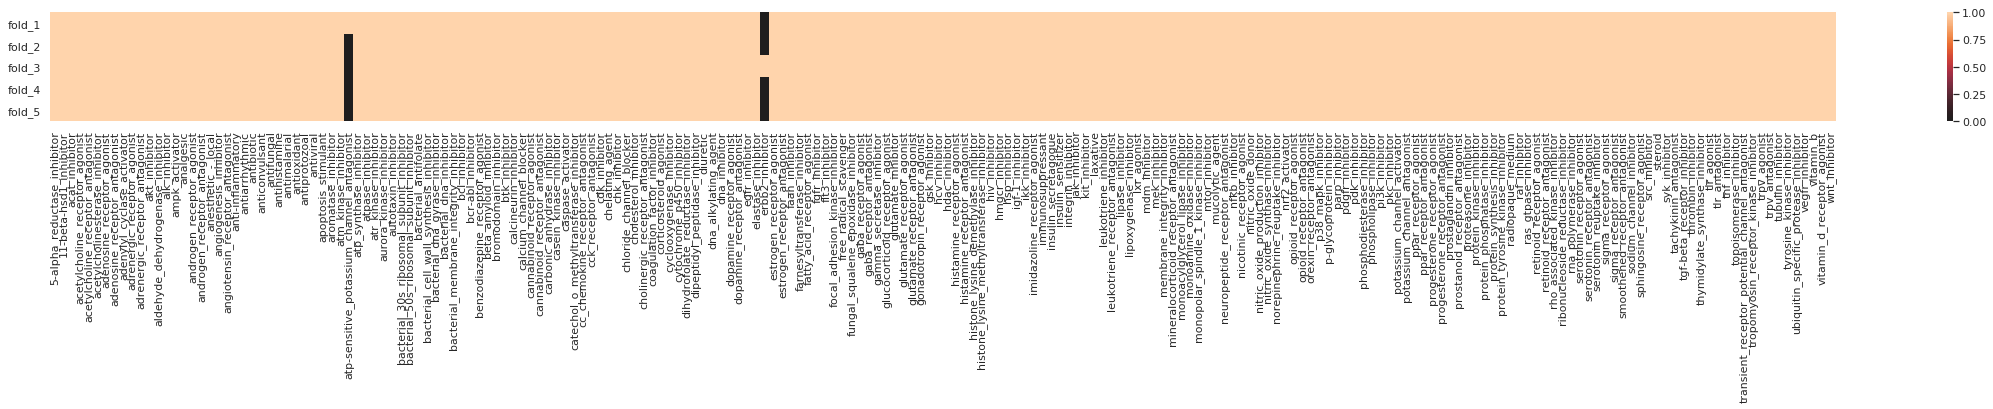

In [56]:
df_bin = df_count_kfold.copy()
df_bin[df_count_kfold==0] = 0
df_bin[df_count_kfold!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)